In [8]:
import kagglehub
import os
import matplotlib.pyplot as plt
import torch
import torch.optim as optim

In [9]:
path = kagglehub.dataset_download("borhanitrash/cat-dataset")
dataset_path = os.path.join(path, "cats", "Data")

In [10]:
from torchvision import transforms
from torch.utils.data import DataLoader
from cat_image_dataset import CatImageDataset

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = CatImageDataset(image_dir=dataset_path, transform=transform)
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [11]:
from torchvision.utils import make_grid

def show_images(images, title="Fake Samples"):
    images = (images + 1) / 2
    grid = make_grid(images[:32], nrow=8)
    npimg = grid.cpu().numpy().transpose((1, 2, 0))
    plt.figure(figsize=(8, 8))
    plt.imshow(npimg)
    plt.title(title)
    plt.axis('off')
    plt.show()

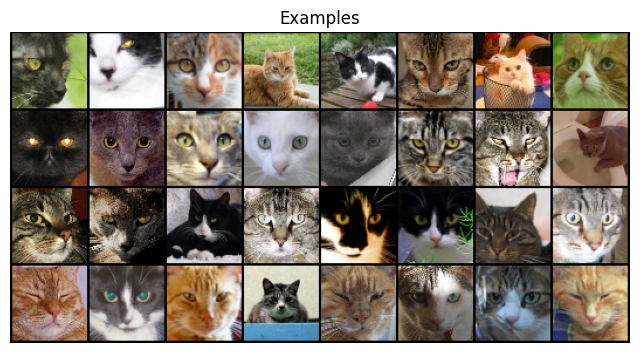

In [12]:
show_images(next(iter(train_loader)), title="Examples")

In [13]:
from generator import Generator
from critic import Critic
from config import Config

def train_wgan(generator: Generator, critic: Critic, dataloader: DataLoader, config: Config):
    generator = generator.to(config.device)
    critic = critic.to(config.device)

    opt_G = optim.RMSprop(generator.parameters(), lr=config.lr)
    opt_C = optim.RMSprop(critic.parameters(), lr=config.lr)

    fixed_noise = torch.randn(64, config.z_dim, 1, 1).to(config.device)

    for epoch in range(config.epochs):
        for i, real_imgs in enumerate(dataloader):
            real_imgs = real_imgs.to(config.device)

            for _ in range(config.n_critic):
                z = torch.randn(real_imgs.size(0), config.z_dim, 1, 1).to(config.device)
                fake_imgs = generator(z).detach()

                critic_real = critic(real_imgs).mean()
                critic_fake = critic(fake_imgs).mean()
                loss_C = -(critic_real - critic_fake)

                opt_C.zero_grad()
                loss_C.backward()
                opt_C.step()

                for p in critic.parameters():
                    p.data.clamp_(-config.clip_value, config.clip_value)

            z = torch.randn(real_imgs.size(0), config.z_dim, 1, 1).to(config.device)
            fake_imgs = generator(z)
            loss_G = -critic(fake_imgs).mean()

            opt_G.zero_grad()
            loss_G.backward()
            opt_G.step()

        print(f"[Epoch {epoch}/{config.epochs}] [D loss: {loss_C.item():.4f}] [G loss: {loss_G.item():.4f}]")

        with torch.no_grad():
            fake = generator(fixed_noise)
            show_images(fake, title=f"Epoch {epoch}")

In [ ]:
cfg = Config(epochs=100)
G = Generator(cfg.z_dim)
C = Critic()

train_wgan(generator=G, critic=C, dataloader=train_loader, config=cfg)

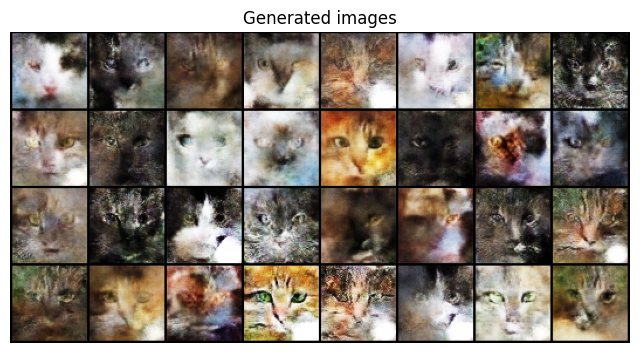

In [15]:
with torch.no_grad():
    fixed_noise = torch.randn(64, cfg.z_dim, 1, 1).to(cfg.device)
    fake = G(fixed_noise)
    show_images(fake, title=f"Generated images")